BI名企班，谢雅楠，20201213

### Thinking
1. 逻辑回归的假设条件是怎样的？  
假设1. 数据服从伯努利分布； 假设2. 正类的概率由sigmoid函数计算  
2. 逻辑回归的损失函数是怎样的？  
Logloss交叉信息熵  
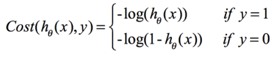

3. 逻辑回归如何进行分类？  
sigmoid函数计算1类的概率；  
设置threshold阈值（通常为0.5），概率大于阈值为1类，小于为0类  
4. 为什么在训练中需要将高度相关的特征去掉？  
相关度高的特征，可以通过线性组合将另一个特征还原，从而形成重复。去掉后，特征数减少，可以提升训练速度，对特征重要性的解释更清晰

### Action
基于评分卡的风控模型开发  
数据集GiveMeSomeCredit，15万样本数据
https://www.kaggle.com/c/GiveMeSomeCredit/data  
使用WOE进行特征变换，IV进行特征筛选，LR构建风控模型，并对模型评分规则进行可解释性说明 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
df_train = pd.read_csv('cs-training.csv')
df_test = pd.read_csv('cs-test.csv')

In [3]:
df_train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [5]:
df_train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

### 1. EDA

In [6]:
## SeriousDlqin2yrs
df_train['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

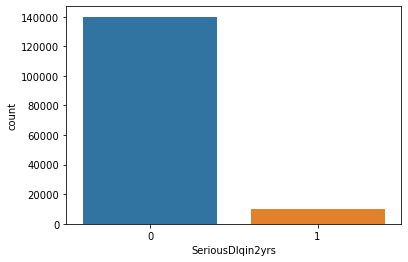

In [7]:
sns.countplot(x='SeriousDlqin2yrs', data=df_train)

In [8]:
## missing value
df_train.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [9]:
df_train['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

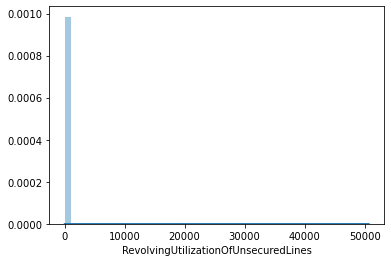

In [10]:
## RevolvingUtilizationOfUnsecuredLines
sns.distplot(df_train['RevolvingUtilizationOfUnsecuredLines'])

### 2. 缺失值

In [11]:
df_train = df_train.fillna(df_train.median())

In [12]:
df_train.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### 3.数据分箱
1）对于age字段，分成6段 [-math.inf, 25, 40, 50, 60, 70, math.inf]  
2）对于NumberOfDependents（家属人数）字段，分成6段
 [-math.inf,2,4,6,8,10,math.inf]  
3）对于3种逾期次数，即NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate，分成10段
[-math.inf,1,2,3,4,5,6,7,8,9,math.inf]  
4）对于其余字段，即RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分成5段


In [13]:
## age
age_bins = [-math.inf, 25, 40, 50, 60, 70, math.inf]  
df_train['bin_age'] = pd.cut(df_train['age'], bins=age_bins)

In [14]:
## dependent
dependent_bins = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'], bins=dependent_bins)
# df_train[['NumberOfDependents','bin_NumberOfDependents']]

In [15]:
## NumberOfTime30-59DaysPastDueNotWorse，
## NumberOfTime60-89DaysPastDueNotWorse，
## NumberOfTimes90DaysLate
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]  
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse']= pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTimes90DaysLate']= pd.cut(df_train['NumberOfTimes90DaysLate'], bins=dpd_bins)

In [16]:
## RevolvingUtilizationOfUnsecuredLines, 
## DebtRatio, 
## MonthlyIncome, 
## NumberOfOpenCreditLinesAndLoans, 
## NumberRealEstateLoansOrLines
df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'], q=5, duplicates='drop') 
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'], q=5, duplicates='drop') 
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'], q=5, duplicates='drop') 
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'], q=5, duplicates='drop') 
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'], q=5, duplicates='drop') 

In [21]:
bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]
bin_cols

['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

### 4.特征筛选
使用IV值衡量自变量的预测能力，筛选IV值>0.1的特征字段


In [40]:
def cal_IV(df, feature, target):
    lst = []
    cols = ['Variable', 'Value', 'All', 'Bad']
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, 
                    val, 
                    len(df[df[feature]==val]), 
                    len(df[(df[feature]==val) & (df[target] == 1)])])
    # print(lst)
    data = pd.DataFrame(lst, columns=cols)
    data = data[data['Bad'] > 0]
    
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Margin Bad'] = data['Bad'] / data['Bad'].sum()
    data['Margin Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['woe'] = np.log(data['Margin Bad'] / data['Margin Good'])
    data['iv'] =  (data['woe'] * (data['Margin Bad'] - data['Margin Good'])).sum()
    data = data.sort_values(by=['Variable', 'Value'])
    # print(data)
    return data['iv'].values[0]
    
    


cal_IV(df_train, 'bin_age', 'SeriousDlqin2yrs')

0.24041120302785982

In [42]:
for f in bin_cols:
    print(f)
    print(cal_IV(df_train, f, 'SeriousDlqin2yrs'))
    print()

bin_age
0.24041120302785982

bin_NumberOfDependents
0.01450836007644442

bin_NumberOfTime30-59DaysPastDueNotWorse
0.492444774570198

bin_NumberOfTime60-89DaysPastDueNotWorse
0.2665587583516951

bin_NumberOfTimes90DaysLate
0.49160685733515563

bin_RevolvingUtilizationOfUnsecuredLines
1.0596188771423887

bin_DebtRatio
0.05948761145809681

bin_MonthlyIncome
0.05623446147714756

bin_NumberOfOpenCreditLinesAndLoans
0.04802315528985505

bin_NumberRealEstateLoansOrLines
0.0120914141106244



In [43]:
## iv>0.1
# bin_age
# bin_NumberOfTime30-59DaysPastDueNotWorse
# bin_NumberOfTime60-89DaysPastDueNotWorse
# bin_NumberOfTimes90DaysLate
# bin_RevolvingUtilizationOfUnsecuredLines
feature_cols = ['bin_age',
                'bin_NumberOfTime30-59DaysPastDueNotWorse',
                'bin_NumberOfTime60-89DaysPastDueNotWorse',
                'bin_NumberOfTimes90DaysLate',
                'bin_RevolvingUtilizationOfUnsecuredLines']



### 5. 对于筛选出来的特征，计算每个bin的WOE值

In [86]:
def cal_WOE(df, features, target):
    df_new = df.copy()
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum', 'count']})
        df_woe.columns = list(map(''.join, df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns={target+'sum': 'bad', target+'count': 'all'})
        
        df_woe['good'] = df_woe['all'] - df_woe['bad']
        df_woe['margin bad'] = df_woe['bad'] / df_woe['bad'].sum()
        df_woe['margin good'] = df_woe['good'] / df_woe['good'].sum()
        df_woe['woe'] =  np.log1p(df_woe['margin bad'] / df_woe['margin good'])
        
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        # print(df_woe)
        df_new = df_new.merge(df_woe, on=f, how='left')
    return df_new



df_woe =  cal_WOE(df_train, bin_cols, 'SeriousDlqin2yrs')
df_woe

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,good_bin_NumberOfOpenCreditLinesAndLoans,margin bad_bin_NumberOfOpenCreditLinesAndLoans,margin good_bin_NumberOfOpenCreditLinesAndLoans,woe_bin_NumberOfOpenCreditLinesAndLoans,bad_bin_NumberRealEstateLoansOrLines,all_bin_NumberRealEstateLoansOrLines,good_bin_NumberRealEstateLoansOrLines,margin bad_bin_NumberRealEstateLoansOrLines,margin good_bin_NumberRealEstateLoansOrLines,woe_bin_NumberRealEstateLoansOrLines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,25838,0.184121,0.184591,0.691873,841,9952,9111,0.083882,0.065091,0.827981
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,24972,0.156892,0.178405,0.630962,7420,108526,101106,0.740076,0.722320,0.705363
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,35145,0.201177,0.251082,0.588475,7420,108526,101106,0.740076,0.722320,0.705363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
149997,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,...,25838,0.184121,0.184591,0.691873,7420,108526,101106,0.740076,0.722320,0.705363
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363


In [87]:
feature_cols = ['age',
                'NumberOfTime30-59DaysPastDueNotWorse',
                'NumberOfTime60-89DaysPastDueNotWorse',
                'NumberOfTimes90DaysLate',
                'RevolvingUtilizationOfUnsecuredLines']

feature_cols

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'RevolvingUtilizationOfUnsecuredLines']

In [88]:
df_bin_to_woe = pd.DataFrame(columns = ['features', 'bin', 'woe'])
for f in feature_cols:
    b = 'bin_'+f
    w = 'woe_bin_' + f
    df = df_woe[[w,b]].drop_duplicates()
    df.columns = ['woe', 'bin']
    df['features'] = f
    df_bin_to_woe = pd.concat([df_bin_to_woe, df])
#     print(df)
df_bin_to_woe

,features,bin,woe
0,age,"(40.0, 50.0]",0.813822
1,age,"(25.0, 40.0]",0.955231
5,age,"(70.0, inf]",0.279404
6,age,"(50.0, 60.0]",0.651655
15,age,"(60.0, 70.0]",0.406848
19,age,"(-inf, 25.0]",1.013134
0,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",1.797837
1,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",0.572521
13,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",2.151185
183,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",2.429111


### 6. 使用逻辑回归进行建模

In [89]:
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
woe_cols

['woe_bin_age',
 'woe_bin_NumberOfDependents',
 'woe_bin_NumberOfTime30-59DaysPastDueNotWorse',
 'woe_bin_NumberOfTime60-89DaysPastDueNotWorse',
 'woe_bin_NumberOfTimes90DaysLate',
 'woe_bin_RevolvingUtilizationOfUnsecuredLines',
 'woe_bin_DebtRatio',
 'woe_bin_MonthlyIncome',
 'woe_bin_NumberOfOpenCreditLinesAndLoans',
 'woe_bin_NumberRealEstateLoansOrLines']

In [90]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_woe[woe_cols], 
                                                    df_woe['SeriousDlqin2yrs'], 
                                                    test_size=0.2,
                                                    random_state=1234)

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

model = LogisticRegression(random_state=1234).fit(x_train, y_train)
y_pred = model.predict(x_test)
print('accuracy: ', accuracy_score(y_pred, y_test))
print('auc: ', roc_auc_score(y_pred, y_test))

accuracy:  0.9361
auc:  0.7670665397646408


### 对评分卡模型的规则进行说明
df_bin_to_woe将筛选出的重要特征分箱并求解出woe，原始特征被转化为相应分箱的woe进行模型输入

In [94]:
df_bin_to_woe

,features,bin,woe
0,age,"(40.0, 50.0]",0.813822
1,age,"(25.0, 40.0]",0.955231
5,age,"(70.0, inf]",0.279404
6,age,"(50.0, 60.0]",0.651655
15,age,"(60.0, 70.0]",0.406848
19,age,"(-inf, 25.0]",1.013134
0,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",1.797837
1,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",0.572521
13,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",2.151185
183,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",2.429111
